In [4]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
import seaborn as sns; sns.set()
import quandl
from IPython.display import Image, display

In [5]:
#start date
yearS=2016
monthS=6
dayS=1

#end date
yearE=2018
monthE=7
dayE=3

#stock ticker
tickers = pd.read_csv('ipsa_tickers.csv')
tickers = tickers.drop(tickers.index[[11,16]])
tickers = tickers.reset_index(drop=True)
#tickers and names of stocks
selected = tickers.Symbol[0:5]
names = tickers['Company Name']

stocks2 = []

#combine 5 stocks into a stockmatrix
for i in range(0,len(selected)):
    stocks = pdr.get_data_yahoo(selected[i], 
                          start=datetime.datetime(yearS,monthS,dayS), 
                          end=datetime.datetime(yearE, monthE, dayE))
    stocks = stocks[['Adj Close']]
    stocks2.append(stocks)
    stocks2[i].rename(columns={'Adj Close':'%s' % (selected[i])}, inplace=True)

table = pd.concat(stocks2,axis=1)

Returns and Covariances

In [6]:
# calculate daily and annual returns of the stocks
returns_daily = table.pct_change()
returns_annual = returns_daily.mean() * 252

# get daily and covariance of returns of the stock
cov_daily = returns_daily.cov()
cov_annual = cov_daily * 252


Markowitz Efficient Frontier 

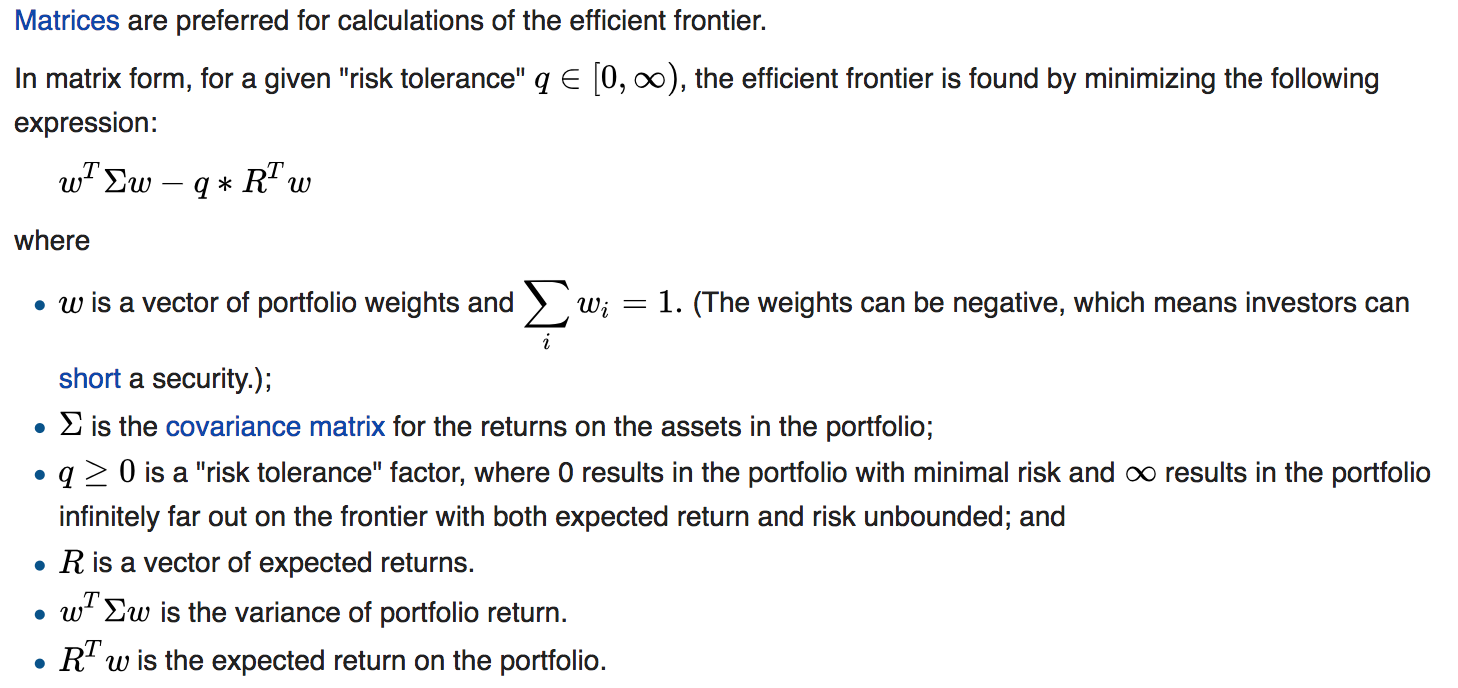

In [7]:
Image(filename=r"/Users/Claudio/Documents/Trading/Markowist Portfolio Theory/wikifrontier.png")

In [8]:
#-----------------#
#The efficient frontier is the set of optimal portfolios that offers 
#the highest expected return for a defined level of risk or 
#the lowest risk for a given level of expected return.

#To get the efficient frontier (efficient set of portfolios),
#we need to simulate imaginary combinations of portfolios 
#(50,000 portfolios of different combinations in this case)

# empty lists to store returns, volatility and weights of imiginary portfolios
port_returns = []
port_volatility = []
stock_weights = []
sharpe_ratio = []
stock_weights = []

# number of combinations for imaginary portfolios
num_assets = len(selected)
num_portfolios = 50000

#set random seed for reproduction's sake
np.random.seed(101)

Sharpe Ratio Criteria

In [9]:
#The Sharpe ratio is the average return earned in excess of the risk-free rate
#per unit of volatility or total risk, simply a measure of the performance 
#of an investment’s returns given its risk

#using sharpe ratio as criteria for choosing best optimal combination
#risk free rate is assumed to be 0% in this example
# populate the empty lists with each portfolios returns,risk and weights
rf = 0
for single_portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    #this is each specific weight divided by the sum of the weights to get
    #weights == 1
    weights /= np.sum(weights)
    returns = np.dot(weights, returns_annual)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    sharpe = (returns - rf)/volatility
    sharpe_ratio.append(sharpe)
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)
    
# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
             'Sharpe Ratio': sharpe_ratio}

In [10]:
# extend original dictionary to accomodate each ticker and weight in the portfolio
for counter,symbol in enumerate(selected):
    portfolio[symbol+' Weight'] = [Weight[counter] for Weight in stock_weights]

# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)

In [11]:
#--------------------------------------------------------------------------#
## locate the optimal portfolio and another portfolio with the 
## minimum volatility for the most risk-averse investor 

#top 5 best and worst performing portfolios
maximum = df.nlargest(5, 'Sharpe Ratio', keep='first')
minimum = df.nsmallest(5, 'Sharpe Ratio', keep='first')

# find min Volatility & max sharpe values in the dataframe (df)
min_volatility = df['Volatility'].min()
max_sharpe = df['Sharpe Ratio'].max()

# use the min, max values to locate and create the two special portfolios
sharpe_portfolio = df.nlargest(1, 'Sharpe Ratio', keep='first')
min_variance_port = df.nsmallest(1, 'Volatility', keep='first')

Text(0.5,1,'Efficient Frontier')

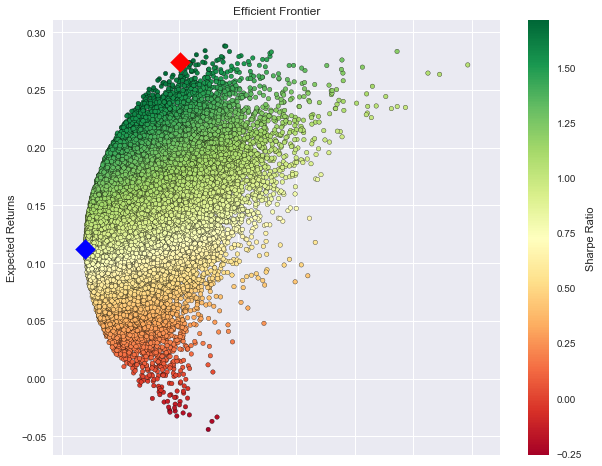

In [12]:
#plot max sharpe ratio and small volatility
#markowitz objective
plt.style.use('seaborn-dark')
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='red', marker='D', s=200)
plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='blue', marker='D', s=200 )
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')

plt.title('Efficient Frontier')